# What is Survival Analysis?

[Survival analysis](https://en.wikipedia.org/wiki/Survival_analysis) is used to study the **time** until some **event** of interest (often reffered to as **death**) occurs.  Time could be measured in years, months, weeks, days, etc.  The event could be anything of interest.  It could be an actual death, a birth, a Pokemon Go server crash, etc. In this post we are interested in how long drafted NFL players are in the league, so the event of interest will be the retirement of drafted NFL players. The duration of time leading up to the event of interest can be called the **survival time**. In our case, the survival time the number of years that a player was active in the league (according to [Pro Football Reference](http://www.pro-football-reference.com/)).  

Some of the players in this analysis are still active players (e.g. Aaron Rodgers, Eli Manning, etc.), so we have yet to observe their retirement (the event of interest).  Those players are considered **censored**. While we have some information about their career length (or survival time), we don't know the full length of their career.  This specific type of censorship, one in which we do not observe end of the survival time, is called **right-censorship**.  The methods developed in the field of survival analysis were created in order to deal with the issue of censored data.  In this post we will use one such method, called the [Kaplan-Meier estimator](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator), to estimate the survival function and construct a survival curve for an NFL career.


## A brief comment on the data used.

I used the draft data scraped from my [previous post](http://savvastjortjoglou.com/nfl-draft.html). The duration of a player's career is just the difference between "To" value from the [PFR draft table](http://www.pro-football-reference.com/years/2015/draft.htm) and the year the player was drafted.  I also was able to find which players were still considered active by just seeing who's name was in bold.  However there are may be some players who are retired that PFR still considers active. You can check out how prepped the data in [this Jupyter notebook](https://github.com/savvastj/nfl_survival_analysis/blob/master/Data_Prep.ipynb). Let me know if you see any issues/mistakes I've made.

# What is the Survival Function?

The [survival function](https://en.wikipedia.org/wiki/Survival_function), $S(t)$, of a population is defined as follows:

$$S(t) = Pr(T > t)$$

Capital $T$ is a [random variable](https://www.khanacademy.org/math/probability/random-variables-topic/random-variables-prob-dist/v/random-variables) that represents a subject's survival time. In our case $T$ represents an NFL player's career length. Lower case $t$ represents a specific time of interest for $T$. In our analysis the $t$ represents the specific number of years for a player's career. 

To put it simply the survival function just gives us the probability that someone survives longer than (or at least as long as) a specified value of time, $t$.  So in the context of our analysis, $S(3)$ will provide us the probability that an NFL career lasts longer than 3 years.

# What is the Kaplan-Meier estimator?

To estimate the survival function of NFL players we will use the Kaplan-Meier estimator.  The Kaplan-Meier estimator is defined by the following product:

$$\hat{S}(t) = \prod_{t_i \lt t} \frac{n_i - d_i}{n_i}$$

where $d_i$ are the number of death events at time $t$ and $n_i$ is the number of subjects at risk of death just prior to time $t$. 

I'll go in a bit more detail regarding the above notation soon, but for now lets start writing up some code.

**NOTE** I just grabbed the above definition stright from the `lifelines` [documentation](https://lifelines.readthedocs.io/en/latest/Intro%20to%20lifelines.html#estimating-the-survival-function-using-kaplan-meier)

# Estimate the Survival Function of NFL Players using the `lifelines` Library.

Lets set things up by importing what we need, reading in the data, and setting up some plot aesthetics.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter

draft_df = pd.read_csv("data/nfl_survival_analysis_data.csv")

# set some plotting aesthetics, similar to ggplot
sns.set(palette = "colorblind", font_scale = 1.35, 
        rc = {"figure.figsize": (12,9), "axes.facecolor": ".92"})

In [2]:
draft_df.head()

Draft_Yr  Rnd  Pick   Tm          Player Pos  Age    To  AP1  PB    ...     \
0      1967    1     1  BAL     Bubba Smith  DE   22  1976    1   2    ...      
1      1967    1     2  MIN     Clint Jones  RB   22  1973    0   0    ...      
2      1967    1     3  SFO  Steve Spurrier  QB   22  1976    0   0    ...      
3      1967    1     4  MIA      Bob Griese  QB   22  1980    2   8    ...      
4      1967    1     5  HOU  George Webster  LB   21  1976    3   3    ...      

   Rec  Rec_Yds  Rec_TD  Tkl  Def_Int   Sk       College  Player_ID  Retired  \
0    0        0       0  0.0        0  0.0  Michigan St.   SmitBu00        1   
1   38      431       0  0.0        0  0.0  Michigan St.   JoneCl00        1   
2    0        0       0  0.0        0  0.0       Florida   SpurSt00        1   
3    0        0       0  0.0        0  0.0        Purdue   GrieBo00        1   
4    0        0       0  0.0        5  0.0  Michigan St.   WebsGe00        1   

   Duration  
0        10  
1         7  
2        10  
3        14  
4        10  

[5 rows x 32 columns]

The columns of interest for our analysis are the *Duration* and *Retired* columns.  The *Duration* column represents the number of years a player played in the NFL.  The *Retired* column represents whether the player retired from the NFL or not.  1 indicates that he did, while 0 indicates that he is still and active player.

Now lets construct the `KaplanMeierFitter` object we will be using in the rest of this post.

In [3]:
kmf = KaplanMeierFitter()

We can then fit the data by calling the `KaplanMeierFitter`s `fit` method.

In [4]:
# The 1st arg accepts an array or pd.Series of individual survival times
# The 2nd arg accepts an array or pd.Series that indicates if the event 
# interest occured.
kmf.fit(durations = draft_df.Duration, 
        event_observed = draft_df.Retired)

<lifelines.KaplanMeierFitter: fitted with 15592 observations, 1629 censored>

## How to Calculate the Kaplan-Meier Estimate.

After fitting our data we can access the survival table used to calculate the Kaplan-Meier Estimate via the `event_table` attribute.

In [5]:
kmf.event_table

removed  observed  censored  entrance  at_risk
event_at                                                
0          4597.0    4504.0      93.0   15592.0  15592.0
1          1310.0    1076.0     234.0       0.0  10995.0
2          1415.0    1176.0     239.0       0.0   9685.0
3          1183.0     952.0     231.0       0.0   8270.0
4          1126.0     942.0     184.0       0.0   7087.0
5           967.0     822.0     145.0       0.0   5961.0
6           915.0     782.0     133.0       0.0   4994.0
7           823.0     715.0     108.0       0.0   4079.0
8           743.0     667.0      76.0       0.0   3256.0
9           662.0     609.0      53.0       0.0   2513.0
10          580.0     523.0      57.0       0.0   1851.0
11          406.0     375.0      31.0       0.0   1271.0
12          313.0     291.0      22.0       0.0    865.0
13          198.0     184.0      14.0       0.0    552.0
14          149.0     146.0       3.0       0.0    354.0
15           88.0      85.0       3.0       0.0    205.0
16           52.0      49.0       3.0       0.0    117.0
17           33.0      33.0       0.0       0.0     65.0
18           11.0      11.0       0.0       0.0     32.0
19            5.0       5.0       0.0       0.0     21.0
20            8.0       8.0       0.0       0.0     16.0
21            5.0       5.0       0.0       0.0      8.0
22            1.0       1.0       0.0       0.0      3.0
23            1.0       1.0       0.0       0.0      2.0
26            1.0       1.0       0.0       0.0      1.0

The *removed* column contains the number of observations removed during that time value, whether due to death (the value in the *observed* column) or censorship. So the *removed* column is just the sum of the *observed* and *censorship* columns.  The *entrance* column tells us whether any new subjects entered the population at that time period.  Since all the players we are studying start at $time = 0$, the *entrance* value is 15,592 at that time and 0 for all other times.

The *at_risk* column contains the number of subjects that are still alive during a given time. The value for *at_risk* at $time = 0$, is just equal to the *entrance* value.  For the remaining time periods, the *entrance* value is equal to the difference between the time previous period's *at_risk* value and *removed* value, plus the current period's *entrance* value. For example for $time = 1$, the number of subject's *at risk*  is 10,995 which is equal to 15,592 (the previous *at_risk* value) - 4,597 (the previous *removed* value) + 0 (the current period's *entrance* value).

Since we have access to the survival table we can calculate the survival probability at different times "by hand."

Let us take a look at the definition of the Kaplan-Meier Estimate again:

$$\hat{S}(t) = \prod_{t_i \lt t} \frac{n_i - d_i}{n_i}$$

where  $d_i$  are the number of death events at time  $t$  and  $n_i$  is the number of subjects at risk of death just prior to time  $t$. 

What the above tells us, is to get the survival probability after a specific time, we multiply all the individual survival probabibilities for all individual time periods leading up to that specific time.

We can define the survival probability for an individual time period as follows:

$$S_t = \frac{\substack{\text{Number of subjects} \\ \text{at risk at the start}} - \substack{\text{Number of subjects} \\ \text{that died}}}{\substack{\text{Number of subjects} \\ \text{at risk at the start}}}$$

Lets walk through a simple example and calculate the the probability that an NFL career lasts longer than 1 year. First we will need to calulculate the individual survival probabilities for $t = 0$ and $t = 1$.

Here's the calcuation for the survival probability time for $t = 0$:

$$S_0 = \frac{15,592 - 4,504}{15,592} = \frac{11,088}{15,592} \approx 0.711$$

And here's the equivalent code:

In [6]:
# get the values for time = 0 from the survival table
event_at_0 = kmf.event_table.iloc[0, :]
# now calculate the survival probability for t = 0
surv_for_0 =  (event_at_0.at_risk - event_at_0.observed) / event_at_0.at_risk
surv_for_0

0.71113391482811694

What the above number means that all drafted players have 71.1% chance of seeing any game action. In other (harsher) words, about 28.9% of drafted players are DOA.

Now let's calulate the survival probability for $t = 1$:

$$S_1 = \frac{10,995 - 1,076}{10,995} = \frac{9,919}{10,995} \approx 0.902$$

In [7]:
# Calculate the survival probability for t = 1
event_at_1 = kmf.event_table.iloc[1, :]
surv_for_1 =  (event_at_1.at_risk - event_at_1.observed) / event_at_1.at_risk
surv_for_1

0.90213733515234196

The value for $S_1$ represents the the conditional probability that if you are one of the players that do not immediately fail once drafted, then you have a 90.2% chance of playing 1 year of football.

To calculate the probability that an NFL career will last more than 1 year, we multiply the two survival probabilities we just calculated:

$$S(1) = S_0 \times S_1 = \frac{11,088}{15,592} \times \frac{9,919}{10,995} \approx 0.642$$

In [8]:
# The probability that an NFL player has a career longer than 1 yr
# is about 64.2%
surv_after_1 = surv_for_0 * surv_for_1
surv_after_1

0.64154045485948996

Hopefully going through that short example gives you a better idea of how the Kaplan-Meier estimator works.  

Our `KaplanMeierFitter` object can do all of the above work for us pretty easily by just using its `predict` method.  The `predict` method can give us the probability that an NFL career lasts more than 1 year by just passing in the value 1.

In [9]:
kmf.predict(1)

0.64154045485948907

That's pretty close to the value we calculated by hand, though it's not exactly the same.  I'm not sure why it isn't exact, but if you do, please let me know.

The `predict` method can also handle an array of numbers.

In [10]:
kmf.predict([1,3,5,10])

array([ 0.64154045,  0.49875796,  0.37282823,  0.11208943])

To get the full list of estimated probabilities from our `KaplanMeierFitter` access the `survival_function_` attribute, which is a `pandas DataFrame` containing all the estimates.

In [11]:
kmf.survival_function_

KM_estimate
timeline             
0.0          0.711134
1.0          0.641540
2.0          0.563641
3.0          0.498758
4.0          0.432463
5.0          0.372828
6.0          0.314448
7.0          0.259329
8.0          0.206205
9.0          0.156233
10.0         0.112089
11.0         0.079018
12.0         0.052435
13.0         0.034957
14.0         0.020540
15.0         0.012023
16.0         0.006988
17.0         0.003440
18.0         0.002258
19.0         0.001720
20.0         0.000860
21.0         0.000323
22.0         0.000215
23.0         0.000108
26.0         0.000000

The `median_` attribute also provides us the number of years where on average 50% of players are out of the league (3 years).

In [12]:
kmf.median_

3.0

## Plotting the Kaplan-Meier Estimate

Plotting the Kaplan-Meier estimate (along with its confidence intervals) is pretty straightfoward. All we need to do is call the `plot` method.

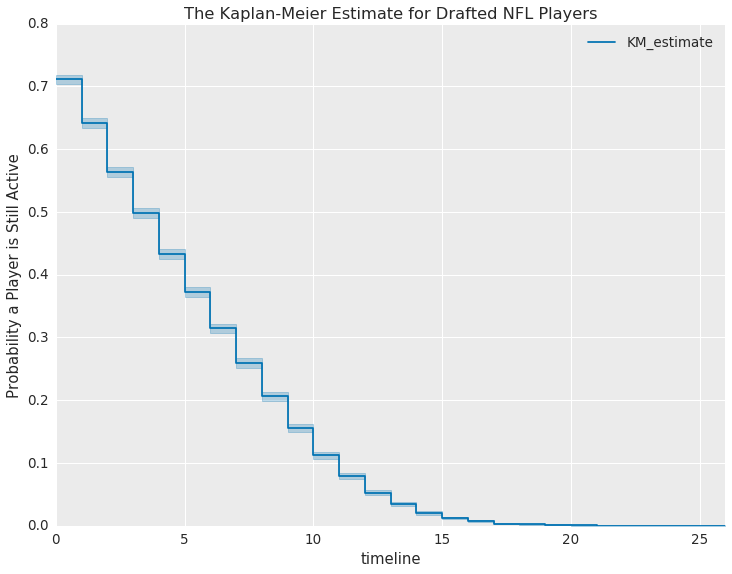

In [13]:
kmf.plot()
plt.title("The Kaplan-Meier Estimate for Drafted NFL Players")
plt.ylabel("Probability a Player is Still Active")

plt.show()

The first thing thing that you should notice is that the Kaplan-Meier estimate is a step function.  Each horizontal line represents the probability that a player is still active after a given time $t$.  For example, when $t = 0$, the probability that a player is still active after that point is about 71%.

### Plotting the Kaplan-Meier Estimate by Position.

Before we plot the career lengths by position, lets clean up some of the data.  We will first merge or even drop some of the player positions.

#### Merge or drop some player positions

In [14]:
draft_df.Pos.unique() # check out all the different positions

array(['DE', 'RB', 'QB', 'LB', 'WR', 'C', 'T', 'DT', 'G', 'HB', 'DB', 'TE',
       'K', 'FL', 'E', 'P', 'FB', 'WB', 'NT', 'KR', 'OL', 'DL', 'OLB',
       'CB', 'FS', 'ILB', 'SS', 'S', 'LS'], dtype=object)

In [15]:
draft_df.Pos.value_counts() # get a count for each position

DB     2668
LB     2039
RB     1798
WR     1793
DE     1242
T      1174
G      1028
DT      987
TE      873
QB      722
C       450
K       197
P       156
NT      134
FB       91
FL       63
OL       39
E        29
CB       29
HB       23
OLB      23
ILB      11
SS        7
FS        5
DL        4
KR        3
WB        2
LS        1
S         1
Name: Pos, dtype: int64

In [16]:
# Relabel/Merge some of the positions
# Set all HBs to RB
draft_df.loc[draft_df.Pos == "HB", "Pos"] = "RB"

# Set all Safetics and Cornernbacks to DBs
draft_df.loc[draft_df.Pos.isin(["SS", "FS", "S", "CB"]), "Pos"] = "DB"

# Set all types of Linebackers to LB
draft_df.loc[draft_df.Pos.isin(["OLB", "ILB"]), "Pos"] = "LB"

In [17]:
# drop players from the following positions [FL, E, WB, KR, LS, OL]
# get the row indices for players with undesired postions
idx = draft_df.Pos.isin(["FL", "E", "WB", "KR", "LS", "DL", "OL"])
# keep the players that don't have the above positions
draft_df_2 = draft_df.loc[~idx, :]

In [18]:
len(draft_df_2.Pos.unique())

15

In [19]:
duration = draft_df_2.Duration
observed = draft_df_2.Retired

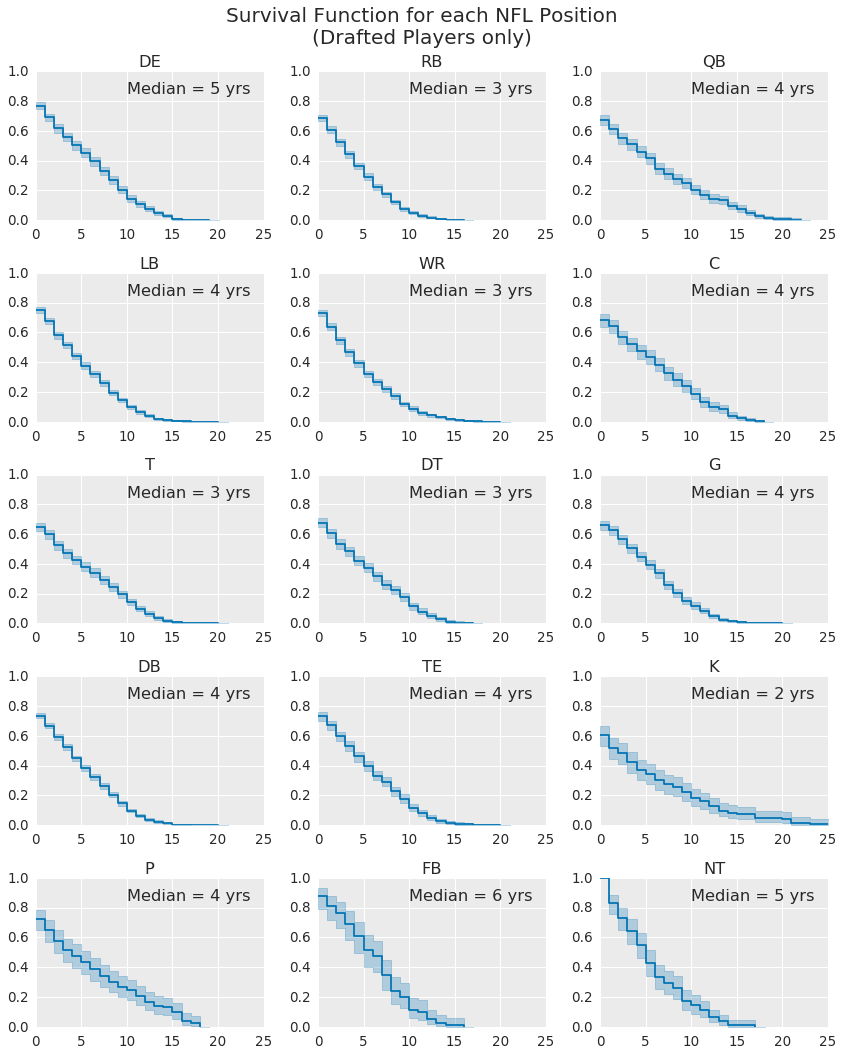

In [20]:
positions = draft_df_2.Pos.unique()

fig = plt.figure(figsize=(12,15))

for i, position in enumerate(positions):
    ax = plt.subplot(5,3,i+1)
    ix = draft_df_2.Pos == position
    kmf.fit( duration[ix], observed[ix], label=position )
    kmf.plot(ax=ax, legend=False)
    ax.annotate("Median = {:.0f} yrs".format(kmf.median_), xy = (.4, .85), 
            xycoords = "axes fraction")
    plt.title(position)
    plt.xlabel("")
    plt.xlim(0,25)
    plt.ylim(0,1)
#     if i==0:
#         plt.ylabel('Frac. in power after $n$ years')
plt.tight_layout()

fig.suptitle("Survival Function for each NFL Position\n(Drafted Players only)",
             fontsize=20)
plt.subplots_adjust(top=0.92)

### TRYING different method to create fecetted survival curve plot, by sharing axes, also try to create a function to do this more easily.

In [ ]:
positions = draft_df_2.Pos.unique()

for i, position in enumerate(positions):
    fig, ax = plt.subplots(5, 3, sharex=True, sharey=True, figsize=(12,15))
    ix = draft_df_2.Pos == position
    kmf.fit( duration[ix], observed[ix], label=position )
    kmf.plot(ax=ax, legend=False)
    ax.annotate("Median = {:.0f} yrs".format(kmf.median_), xy = (.4, .85), 
            xycoords = "axes fraction")
    plt.title(position)
    plt.xlabel("")
    plt.xlim(0,25)
    plt.ylim(0,1)
#     if i==0:
#         plt.ylabel('Frac. in power after $n$ years')
plt.tight_layout()

fig.suptitle("Survival Function for each NFL Position\n(Drafted Players only)",
             fontsize=20)
plt.subplots_adjust(top=0.92)

In [ ]:
for i, a in enumerate(ax.flatten()):a.plot(x,x**i

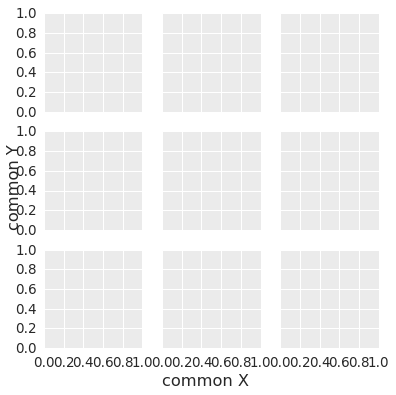

In [42]:
fig, ax = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(6, 6))

fig.text(0.5, 0.04, 'common X', ha='center')
fig.text(0.04, 0.5, 'common Y', va='center', rotation='vertical')


# TODO
- Try by games played
- Try RBs by carries
- Then delve into explanations
- Leave Hazard function for another post?

# Sources

http://www.csee.wvu.edu/~xinl/library/papers/math/statistics/kaplan.pdf
https://lifelines.readthedocs.io/en/latest/Intro%20to%20lifelines.html
https://www.amazon.com/Survival-Analysis-Self-Learning-Statistics-Biology/dp/1441966455/ref=sr_1_1?ie=UTF8&qid=1469425536&sr=8-1&keywords=survival+analysis
https://www.cscu.cornell.edu/news/statnews/stnews78.pdf
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3932959/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3059453/
http://www.garfield.library.upenn.edu/classics1983/A1983QS51100001.pdf